In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.autograd import Variable

In [4]:
BATCH_SIZE = 2680
TIME_STEP = 3
INPUT_SIZE = 33
LR = 1e-6

In [5]:
x = pd.read_csv("drive/My Drive/Colab Notebooks/fiber_model_ook/3dbminput.csv", header=None, skiprows=50)
x = np.array(x)
x = x.reshape(2680, 3, 32)
# x = x.transpose([1,2,0])
x = np.insert(x, 32, values=20, axis=2)
x = torch.Tensor(x)
# x = torch.from_numpy(x)

In [6]:
y = pd.read_csv("drive/My Drive/Colab Notebooks/fiber_model_ook/3dbmoutput20.csv", header=None, skiprows=50)
y = np.array(y)
y = y.reshape(2680, 3, 32)
# y = y.transpose([1,2,0])
y = torch.Tensor(y)
# y = torch.from_numpy(y)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
x = x.to(device)
y = y.to(device)

In [9]:
class RNN(nn.Module):
  def __init__(self):
    super(RNN, self).__init__()
    self.rnn = nn.LSTM(
        input_size=INPUT_SIZE,
        hidden_size=64,
        num_layers=3,
        batch_first=True,
        bidirectional=True
    )
    self.out = nn.Linear(128,32)

  def forward(self, x):
    # x shape (batch, time_step, input_size)
    # r_out shape (batch, time_step, output_size)
    # h_n shape (n_layers, batch, hidden_size)
    # h_c shape (n_layers, batch, hidden_size)
    r_out, (h_n, h_c) = self.rnn(x, None)
    #print(r_out.shape)

    # choose r_out at the last time step
    out = self.out(r_out)
    #print(out.shape)

    return out

In [10]:
rnn = RNN()
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
loss_func = nn.MSELoss()
rnn.cuda()

RNN(
  (rnn): LSTM(33, 64, num_layers=3, batch_first=True, bidirectional=True)
  (out): Linear(in_features=128, out_features=32, bias=True)
)

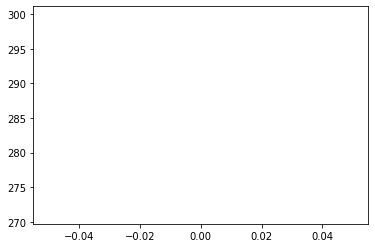

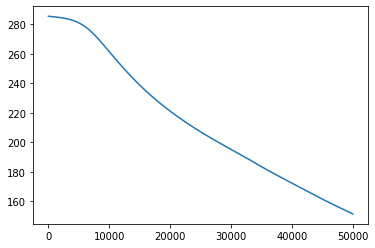

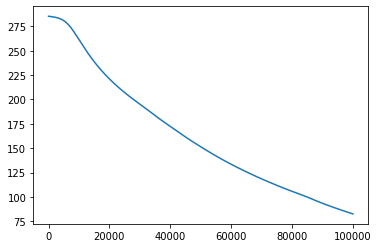

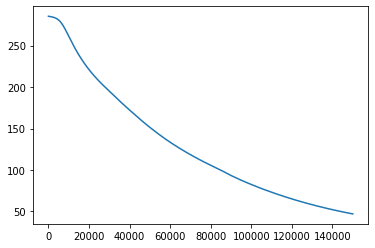

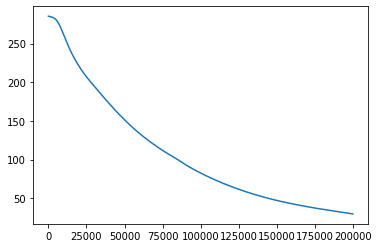

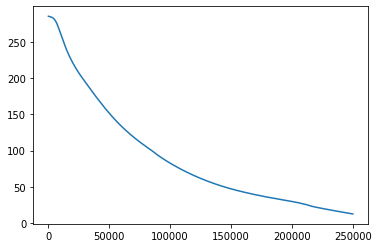

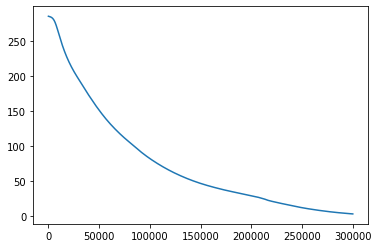

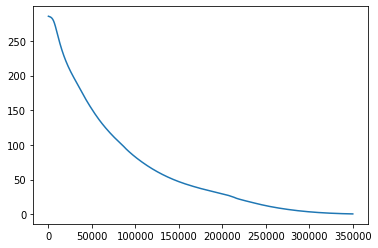

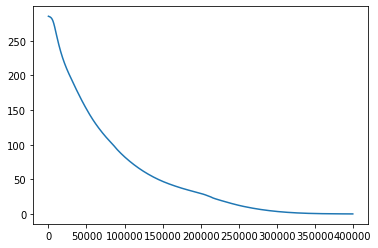

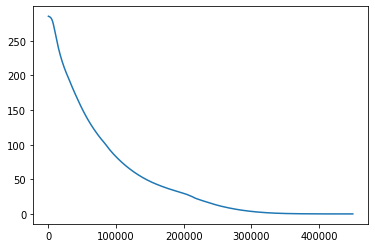

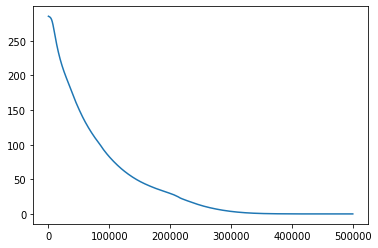

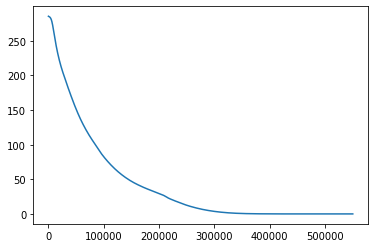

In [11]:
# training and testing
loss_all = []
for i in range(600000):
  # var_x = Variable(x)
  # var_y = Variable(y)
  # var_x = var_x.to(device)
  # var_y = var_y.to(device)
  out = rnn(x)
  loss = loss_func(out, y)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  loss_all.append(loss)
  if i%50000 == 0:
    plt.plot(loss_all)
    plt.show()

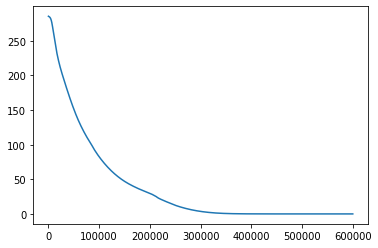

In [12]:
plt.plot(loss_all)

In [13]:
min(loss_all)

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>)

In [14]:
x.shape

torch.Size([2680, 3, 33])

In [15]:
out

tensor([[[2.5423e+01, 2.5799e+01, 2.6071e+01,  ..., 1.9752e+00,
          1.5488e+00, 1.2474e+00],
         [1.0481e+00, 9.3676e-01, 8.8309e-01,  ..., 2.3630e+01,
          2.4261e+01, 2.4745e+01],
         [2.5094e+01, 2.5328e+01, 2.5467e+01,  ..., 2.5259e+01,
          2.5313e+01, 2.5375e+01]],

        [[2.5647e+01, 2.5781e+01, 2.5899e+01,  ..., 2.2142e+00,
          1.7204e+00, 1.3195e+00],
         [9.9552e-01, 7.4380e-01, 5.4882e-01,  ..., 2.2263e-02,
          2.3887e-02, 2.5633e-02],
         [2.5806e-02, 2.8071e-02, 2.8093e-02,  ..., 1.5155e-02,
          2.0623e-02, 2.5395e-02]],

        [[2.4132e-02, 2.3258e-02, 2.5458e-02,  ..., 2.4584e-02,
          2.5488e-02, 2.5395e-02],
         [2.5164e-02, 2.3912e-02, 2.5030e-02,  ..., 2.5231e-02,
          2.5724e-02, 2.5488e-02],
         [2.5728e-02, 2.5420e-02, 2.5177e-02,  ..., 1.7700e-02,
          2.0884e-02, 2.6060e-02]],

        ...,

        [[2.5646e+01, 2.5777e+01, 2.5895e+01,  ..., 1.9454e+00,
          1.5298e+00, 1.2

In [16]:
max(loss_all)

tensor(285.4243, device='cuda:0', grad_fn=<MseLossBackward>)

In [17]:
out-y

tensor([[[-2.8151e-02, -2.7300e-02, -2.7235e-02,  ...,  2.6538e-03,
           1.7974e-03,  1.4737e-03],
         [-9.8050e-04,  2.3010e-03,  1.7827e-03,  ...,  4.6349e-04,
           1.5717e-03,  2.3365e-03],
         [-6.1035e-05, -7.6103e-04, -1.3351e-04,  ..., -3.6726e-02,
          -8.2127e-02, -1.4081e-01]],

        [[-2.7828e-03, -2.9392e-03, -2.6093e-03,  ..., -3.0756e-05,
          -3.5286e-04,  7.2420e-04],
         [-1.9124e-03, -1.2144e-03, -1.2950e-03,  ..., -1.0326e-03,
          -5.4829e-04,  2.1585e-04],
         [-4.2895e-04,  1.1726e-03,  6.8028e-04,  ..., -9.7843e-03,
          -4.3034e-03,  4.7504e-04]],

        [[-7.9384e-04, -1.6735e-03,  5.1416e-04,  ..., -6.4992e-04,
           2.4922e-04,  1.6817e-04],
         [-5.2450e-05, -1.3143e-03, -2.0597e-04,  ..., -1.3338e-04,
           3.1267e-04,  1.5837e-04],
         [ 5.8600e-04,  4.7358e-04,  3.1412e-04,  ...,  1.1423e-02,
           7.1266e-03, -2.0522e-03]],

        ...,

        [[-3.3264e-03, -2.5444e-03,